In [1]:
import os
os.chdir("../../../../")

import numpy as np
import scipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet

import pmdarima
from scripts.python.tsmodel import *
from scripts.python.ts_utils import *
from datetime import timedelta

import warnings
warnings.filterwarnings('ignore')

## Load and Merge

In [2]:
data_folder = os.getcwd() + "/data/tourism"
samoa_folder = data_folder + "/samoa/"

In [3]:
samoa = (pd.read_csv(samoa_folder + "intermediate/samoa_byCon.csv")
           .drop("Unnamed: 0", axis=1))

samoa["Date"] = pd.to_datetime(samoa["Date"])
samoa["Date"] = samoa["Date"] - timedelta(days=7)

samoa[["Year", "Month"]].groupby("Year").count()
samoa.head(5)

,Date,Total arrivals (persons),American Samoa,Australia,Europe,New Zealand,USA,Other Countries,Cruise ships,Year,Month
0,2002-08-01,8260.0,2877.0,1115.0,429.0,2035.0,933.0,871.0,0.0,2002.0,8.0
1,2002-09-01,6708.0,2119.0,972.0,372.0,1879.0,612.0,754.0,0.0,2002.0,9.0
2,2002-10-01,5737.0,1892.0,737.0,468.0,1492.0,577.0,571.0,0.0,2002.0,10.0
3,2002-11-01,6653.0,2530.0,864.0,393.0,1675.0,483.0,708.0,0.0,2002.0,11.0
4,2002-12-01,13042.0,4678.0,1918.0,272.0,4401.0,1007.0,766.0,0.0,2002.0,12.0


In [4]:
covid = pd.read_csv(data_folder + "/owid-covid-data.csv")
covid_si = (covid[covid.continent == "Oceania"][["location", "date", "stringency_index"]]
            .reset_index()
            .drop("index", axis=1))
si_mean = covid_si.groupby("date").mean().reset_index()
si_mean["date"] = pd.to_datetime(si_mean["date"])

In [5]:
si_mean["year"], si_mean["month"] = si_mean["date"].dt.year, si_mean["date"].dt.month
si_mean = si_mean.groupby(["year", "month"]).mean().reset_index()
si_mean["date"] = [str(year) + "-" + str(month) for year, month in zip(si_mean.year, si_mean.month)]
si_mean["date"] = pd.to_datetime(si_mean["date"])
si_mean.head(5)

,year,month,stringency_index,date
0,2020,1,6.485000,2020-01-01
1,2020,2,18.961379,2020-02-01
2,2020,3,41.960753,2020-03-01
3,2020,4,82.458000,2020-04-01
4,2020,5,64.930000,2020-05-01


In [6]:
samoa = (samoa.merge(si_mean, how="left", left_on="Date", right_on="date")
         .drop("date", axis=1)
         .fillna(0)
         .rename({"Total arrivals (persons)": "Total",
                  "stringency_index": "covid"}, axis=1))
samoa.head(5)

,Date,Total,American Samoa,Australia,Europe,New Zealand,USA,Other Countries,Cruise ships,Year,Month,year,month,covid
0,2002-08-01,8260.0,2877.0,1115.0,429.0,2035.0,933.0,871.0,0.0,2002.0,8.0,0.0,0.0,0.0
1,2002-09-01,6708.0,2119.0,972.0,372.0,1879.0,612.0,754.0,0.0,2002.0,9.0,0.0,0.0,0.0
2,2002-10-01,5737.0,1892.0,737.0,468.0,1492.0,577.0,571.0,0.0,2002.0,10.0,0.0,0.0,0.0
3,2002-11-01,6653.0,2530.0,864.0,393.0,1675.0,483.0,708.0,0.0,2002.0,11.0,0.0,0.0,0.0
4,2002-12-01,13042.0,4678.0,1918.0,272.0,4401.0,1007.0,766.0,0.0,2002.0,12.0,0.0,0.0,0.0


In [7]:
get_adf_df(samoa, ["Total"])

,Test Statistic,p-value,# Lags Used,Number of Observations Used,Critical Value (1%),Critical Value (5%),Critical Value (10%)
Total,-3.403589,0.010837,14.0,227.0,-3.45949,-2.874358,-2.573602


## SARIMAX

training size : 229, testing size : 13
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=708.514, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=716.059, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=675.134, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=655.690, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=714.096, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=657.804, Time=0.02 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=650.523, Time=0.23 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=630.359, Time=0.86 sec
 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=inf, Time=0.75 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(1,1,1)(1,0,2)[12] intercept   : AIC=629.448, Time=0.87 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=649.272, Time=0.33 sec
 ARIMA(1,1

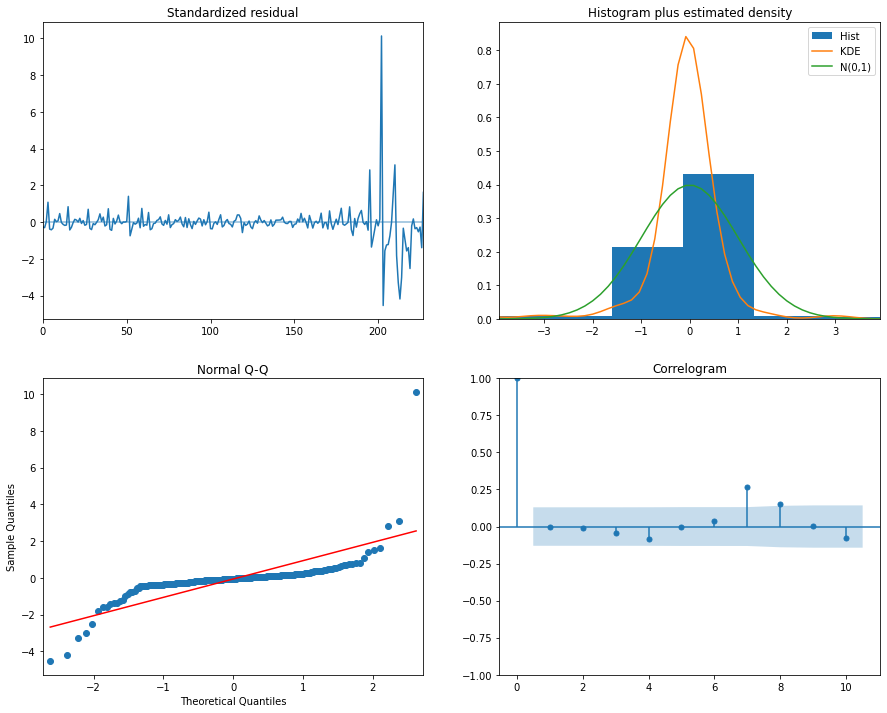

In [8]:
ss = SARIMAXPipeline(data=samoa, y_var="Total",
                     exog_var="covid", transform_method="scaledlogit", training_ratio=0.95)
ss.transform()
ss_sw = ss.stepwise_search()

In [9]:
# Set parameter range
p, d, q = range(0, 3), [0], range(0, 3)
P, D, Q, s = range(0, 3), [0], range(0, 3), [12]

# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
all_param = list(itertools.product(pdq, seasonal_pdq))
ss.manual_search(all_param)

Tried out SARIMAX(0, 0, 0)x(0, 0, 0, 12) - AIC:731.22
Tried out SARIMAX(0, 0, 0)x(0, 0, 1, 12) - AIC:730.57
Tried out SARIMAX(0, 0, 0)x(0, 0, 2, 12) - AIC:730.68
Tried out SARIMAX(0, 0, 0)x(1, 0, 0, 12) - AIC:730.08
Tried out SARIMAX(0, 0, 0)x(1, 0, 1, 12) - AIC:721.34
Tried out SARIMAX(0, 0, 0)x(1, 0, 2, 12) - AIC:721.67
Tried out SARIMAX(0, 0, 0)x(2, 0, 0, 12) - AIC:729.1
Tried out SARIMAX(0, 0, 0)x(2, 0, 1, 12) - AIC:722.18
Tried out SARIMAX(0, 0, 0)x(2, 0, 2, 12) - AIC:725.27
Tried out SARIMAX(0, 0, 1)x(0, 0, 0, 12) - AIC:681.23
Tried out SARIMAX(0, 0, 1)x(0, 0, 1, 12) - AIC:679.13
Tried out SARIMAX(0, 0, 1)x(0, 0, 2, 12) - AIC:678.71
Tried out SARIMAX(0, 0, 1)x(1, 0, 0, 12) - AIC:678.24
Tried out SARIMAX(0, 0, 1)x(1, 0, 1, 12) - AIC:664.36
Tried out SARIMAX(0, 0, 1)x(1, 0, 2, 12) - AIC:665.13
Tried out SARIMAX(0, 0, 1)x(2, 0, 0, 12) - AIC:676.55
Tried out SARIMAX(0, 0, 1)x(2, 0, 1, 12) - AIC:665.51
Tried out SARIMAX(0, 0, 1)x(2, 0, 2, 12) - AIC:668.35
Tried out SARIMAX(0, 0, 2)x(0

[(<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x169c02850>,
  731.2201388160213,
  ((0, 0, 0), (0, 0, 0, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x169d1e040>,
  730.5704391425479,
  ((0, 0, 0), (0, 0, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x169d05100>,
  730.6844347713552,
  ((0, 0, 0), (0, 0, 2, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x169f31ca0>,
  730.0780983692034,
  ((0, 0, 0), (1, 0, 0, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x169c75070>,
  721.3370913707492,
  ((0, 0, 0), (1, 0, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x169ccc430>,
  721.6662608567578,
  ((0, 0, 0), (1, 0, 2, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x169c75220>,
  729.0993777321119,
  ((0, 0, 0), (2, 0, 0, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x169e8b6d0>,
  722.1762791328653,

In [10]:
ss_msres = ss.manual_search_results
ss_msres.sort(key=lambda x: x[1])
ss_msres

[(<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x16bdb3d30>,
  629.99083710796,
  ((2, 0, 1), (1, 0, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x16bbc5730>,
  630.022142437615,
  ((1, 0, 2), (1, 0, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x16bac0b50>,
  630.7404618448534,
  ((1, 0, 1), (1, 0, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x16bdcef10>,
  631.1853356513764,
  ((2, 0, 1), (1, 0, 2, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x16bbc57c0>,
  631.1903881307455,
  ((1, 0, 2), (1, 0, 2, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x16bdf6070>,
  631.2961165052741,
  ((2, 0, 1), (2, 0, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x16bc17df0>,
  631.3637182848323,
  ((1, 0, 2), (2, 0, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x16baddac0>,
  632.0082306539333,
  

In [11]:
ss_models = []
ss_models.append(pm.ARIMA(
    ss_sw["order"], ss_sw["seasonal_order"],  exog=ss.exog[:ss.training_size]))

for res in ss_msres[:5]:
    order, seasonal_order = res[-1]
    model = pm.ARIMA(order, seasonal_order, exog=ss.exog[:ss.training_size])
    ss_models.append(model)
    
ss_comp = ss.compare_models(
    ss.transformed_y[:ss.training_size], ss.exog[:ss.training_size], ss_models)

[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................
[CV] fold=11 .........................................................
[CV] fold=12 .........................................................
[CV] fold=13 .........................................................
[CV] f

[CV] fold=12 .........................................................
[CV] fold=13 .........................................................
[CV] fold=14 .........................................................
[CV] fold=15 .........................................................
[CV] fold=16 .........................................................
[CV] fold=17 .........................................................
[CV] fold=18 .........................................................
[CV] fold=19 .........................................................
[CV] fold=20 .........................................................
[CV] fold=21 .........................................................
[CV] fold=22 .........................................................
[CV] fold=23 .........................................................
[CV] fold=24 .........................................................
[CV] fold=25 .........................................................
[CV] f

In [12]:
ss_comp

{'model': [ARIMA(order=(1, 1, 1), seasonal_order=(1, 0, 2, 12)),
  ARIMA(order=(2, 0, 1), seasonal_order=(1, 0, 1, 12)),
  ARIMA(order=(1, 0, 2), seasonal_order=(1, 0, 1, 12)),
  ARIMA(order=(1, 0, 1), seasonal_order=(1, 0, 1, 12)),
  ARIMA(order=(2, 0, 1), seasonal_order=(1, 0, 2, 12)),
  ARIMA(order=(1, 0, 2), seasonal_order=(1, 0, 2, 12))],
 'cv_scores': [array([ 29.1686177 , 115.90078209,  73.50747065, 127.83760427,
          27.11176445, 180.56842147,  52.5997046 , 191.21442706,
          93.85136918, 177.58707712,  78.52355878, 200.        ,
         165.20196776, 200.        ,  48.51923822, 187.05881103,
          81.8758832 , 189.51550837, 178.78162921, 174.21832472,
          59.41069473, 161.24264966,  67.96919458, 170.7712986 ,
          72.20192779, 174.16321735, 124.10589839, 167.52767864,
         128.33300136, 143.27770736,  93.08721356, 145.96649109,
         191.86135831,  49.73310839,  24.01465764]),
  array([ 28.48502149,  27.19206055,  37.37381065,  37.05388546,
   

In [13]:
best_ss = ss_msres[2][0]
best_ss.save(samoa_folder + "/model/best_scaled.pkl")
best_ss_mod = ss.get_prediction_df(
    best_ss, 13, ss.exog[-ss.test_size:])
lower = samoa["Total"].min() - 1
upper = samoa["Total"].max() + 1

for col_idx, col in enumerate(best_ss_mod.columns):
    for row_idx, _ in enumerate(best_ss_mod[col]):
        best_ss_mod.iloc[row_idx, col_idx] = ss.inverse_scaledlogit(
            best_ss_mod.iloc[row_idx, col_idx], upper, lower)
        
best_ss_mod = pd.concat([samoa[["Date", "Total"]], best_ss_mod], axis=1)
best_ss_mod.head(20)

,Date,Total,train_pred,mean_se,mean_ci_lower,mean_ci_upper,test_pred
0,2002-08-01,8260.0,12323.500000,21180.062113,689.509976,23957.490024,NaN
1,2002-09-01,6708.0,9041.257045,18461.929168,1567.386249,20498.309050,NaN
2,2002-10-01,5737.0,7911.226720,18136.890764,1470.127313,19195.997818,NaN
3,2002-11-01,6653.0,7030.908786,18056.388628,1292.379664,18290.287926,NaN
4,2002-12-01,13042.0,7070.516140,18031.216335,1314.707286,18279.255200,NaN
5,2003-01-01,7555.0,9722.761722,18021.377372,2069.018145,20269.642308,NaN
6,2003-02-01,5968.0,8805.759166,18016.346561,1790.698155,19660.732632,NaN
7,2003-03-01,5550.0,7606.938402,18012.955813,1460.693545,18725.325010,NaN
8,2003-04-01,7283.0,6832.589651,18010.096393,1266.818495,18010.166686,NaN
9,2003-05-01,7190.0,7224.347044,18007.301480,1365.403298,18376.247070,NaN


Text(0.5, 1.0, "Samoa's Visitor Arrivals")

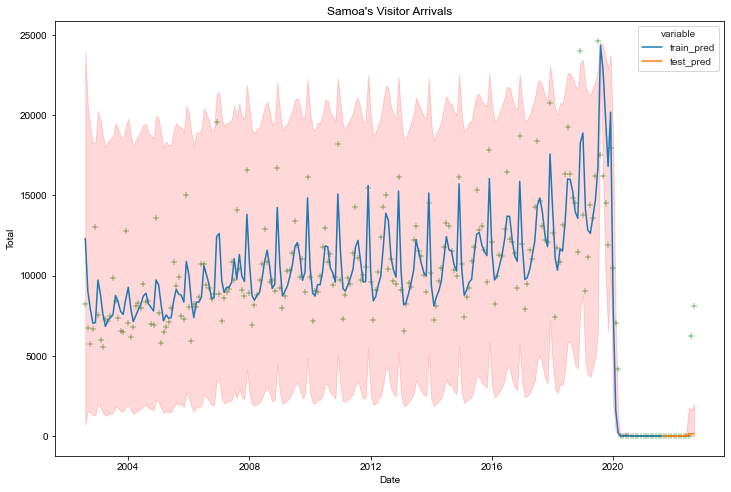

In [14]:
ss_viz_df = best_ss_mod[["Date", "train_pred", "test_pred"]].melt(id_vars=["Date"])
ss_viz_df["Date"] = pd.to_datetime(ss_viz_df["Date"])

fig, ax = plt.subplots(figsize=(12,8))
sns.set_style("whitegrid")
sns.scatterplot(x="Date", y="Total", data=best_ss_mod, color="green", marker="+")
ax.fill_between(x="Date", y1="mean_ci_lower", y2="mean_ci_upper", alpha=0.15, color="red", data=best_ss_mod)
sns.lineplot(data=ss_viz_df, x="Date", y="value", hue="variable")
plt.title("Samoa's Visitor Arrivals")

## VARMAX

In [15]:
samoa_merged = (pd.read_csv(samoa_folder + "intermediate/samoa_merged.csv")
                   .drop("Unnamed: 0", axis=1))

samoa_merged["date"] = [str(y) + "-" + str(m) for y,m in zip(samoa_merged.Year, samoa_merged.Month)]
samoa_merged["date"] = pd.to_datetime(samoa_merged["date"])
samoa_merged = (samoa_merged.merge(si_mean, how="left", on="date")
                            .drop(["year", "month"],axis=1))
samoa_merged.head(5)

,Year,Month,Number_of_flights_intl,Number_of_flights_total,Seats_arrivals_intl,Seats_arrivals_total,Total arrivals (persons),American Samoa,Australia,Europe,New Zealand,USA,Other Countries,Cruise ships,date,stringency_index
0,2019,1,90.0,93.0,26332.0,26389.0,13755.0,1116.0,3434.0,612.0,6290.0,862.0,1441.0,500.0,2019-01-01,NaN
1,2019,2,71.0,84.0,17320.0,17681.0,9044.0,968.0,1820.0,458.0,3645.0,594.0,1559.0,2180.0,2019-02-01,NaN
2,2019,3,85.0,109.0,20843.0,21546.0,11163.0,1089.0,2481.0,716.0,4400.0,981.0,1496.0,6730.0,2019-03-01,NaN
3,2019,4,84.0,117.0,20801.0,21751.0,14413.0,1204.0,3122.0,658.0,6887.0,827.0,1715.0,2519.0,2019-04-01,NaN
4,2019,5,85.0,115.0,20843.0,21679.0,13565.0,1215.0,3143.0,492.0,5742.0,962.0,2011.0,0.0,2019-05-01,NaN


## Ratio Approch

In [16]:
gt = pd.read_csv(os.getcwd() + "/data/tourism/trends/trends_samoa.csv").drop("Unnamed: 0", axis=1)
gt["date"] = pd.to_datetime(gt["date"])
gt.head(5)

,date,samoa flights-AU,samoa hotel-AU,samoa travel-AU,samoa flights-NZ,samoa hotel-NZ,samoa travel-NZ,samoa flights-US,samoa hotel-US,samoa travel-US,...,samoa travel-JP,samoa flights-HK,samoa hotel-HK,samoa travel-HK,samoa flights-NC,samoa hotel-NC,samoa travel-NC,samoa flights,samoa hotel,samoa travel
0,2004-01-01,0,0,0,0,100,97,39,89,33,...,0,0,0,0,0,0,0,2.932001,6.204171,2.053351
1,2004-02-01,70,0,0,0,0,0,74,0,0,...,0,0,0,0,0,0,0,0.000000,2.418118,0.000000
2,2004-03-01,0,0,100,0,67,0,0,0,95,...,0,0,0,0,0,0,0,5.037995,8.828593,5.387750
3,2004-04-01,0,0,53,0,0,0,84,34,0,...,0,0,0,0,0,0,0,2.341915,0.000000,0.000000
4,2004-05-01,0,0,0,0,31,0,36,95,48,...,0,0,0,0,0,0,0,7.196212,6.196599,3.525939


In [17]:
samoa_merged["ratio"] = (samoa_merged["Total arrivals (persons)"])/(samoa_merged["Seats_arrivals_intl"])
samoa_merged = samoa_merged.merge(gt[["samoa flights", "samoa travel", "date"]], how="left", on="date")
samoa_merged.head(5)

,Year,Month,Number_of_flights_intl,Number_of_flights_total,Seats_arrivals_intl,Seats_arrivals_total,Total arrivals (persons),American Samoa,Australia,Europe,New Zealand,USA,Other Countries,Cruise ships,date,stringency_index,ratio,samoa flights,samoa travel
0,2019,1,90.0,93.0,26332.0,26389.0,13755.0,1116.0,3434.0,612.0,6290.0,862.0,1441.0,500.0,2019-01-01,NaN,0.522368,2.710557,0.978500
1,2019,2,71.0,84.0,17320.0,17681.0,9044.0,968.0,1820.0,458.0,3645.0,594.0,1559.0,2180.0,2019-02-01,NaN,0.522171,2.282447,0.713992
2,2019,3,85.0,109.0,20843.0,21546.0,11163.0,1089.0,2481.0,716.0,4400.0,981.0,1496.0,6730.0,2019-03-01,NaN,0.535575,1.909826,0.648102
3,2019,4,84.0,117.0,20801.0,21751.0,14413.0,1204.0,3122.0,658.0,6887.0,827.0,1715.0,2519.0,2019-04-01,NaN,0.692899,2.071637,0.668381
4,2019,5,85.0,115.0,20843.0,21679.0,13565.0,1215.0,3143.0,492.0,5742.0,962.0,2011.0,0.0,2019-05-01,NaN,0.650818,1.872448,0.979695


In [24]:
temp = (samoa_merged[["ratio", "stringency_index", "date", "samoa flights", "samoa travel"]]
        .reset_index()
        .drop("index", axis=1)
        .rename({"samoa flights": "samoa_flights",
                 "samoa travel": "samoa_travel"}, axis=1)
        .fillna(0))
temp["covid"] = (temp.date >= "2020-03-12")
temp["quarter"] = temp["date"].dt.quarter
temp.head(5)

,ratio,stringency_index,date,samoa_flights,samoa_travel,covid,quarter
0,0.522368,0.0,2019-01-01,2.710557,0.978500,False,1
1,0.522171,0.0,2019-02-01,2.282447,0.713992,False,1
2,0.535575,0.0,2019-03-01,1.909826,0.648102,False,1
3,0.692899,0.0,2019-04-01,2.071637,0.668381,False,2
4,0.650818,0.0,2019-05-01,1.872448,0.979695,False,2


In [25]:
import statsmodels.formula.api as smf
res = smf.wls(
    formula="ratio ~ covid * stringency_index + C(quarter) + samoa_travel", data=temp).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  ratio   R-squared:                       0.850
Model:                            WLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     29.93
Date:                Mon, 13 Mar 2023   Prob (F-statistic):           2.19e-13
Time:                        15:06:01   Log-Likelihood:                 30.672
No. Observations:                  45   AIC:                            -45.34
Df Residuals:                      37   BIC:                            -30.89
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          0.3445      0.133      2.597      0.013       0.076       0.613
covid[T.True]                     -0.3052      0.116     -2.640      0.012      -0.539      -0.071
C(quarter)[T.2]                    0.0400      0.062      0.646      0.522      -0.086       0.166
C(quarter)[T.3]                    0.1385      0.062      2.221      0.033       0.012       0.265
C(quarter)[T.4]                    0.0512      0.062      0.822      0.416      -0.075       0.177
stringency_index                  -0.0100      0.004     -2.260      0.030      -0.019      -0.001
covid[T.True]:stringency_index     0.0047      0.006      0.828      0.413      -0.007       0.016
samoa_travel                       0.2829      0.151      1.878      0.068      -0.022       0.588
==============================================================================
Omnibus:                       17.060   Durbin-Watson:                   0.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.071
Skew:                           1.093   Prob(JB):                     1.32e-06
Kurtosis:                       6.108   Cond. No.                         562.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

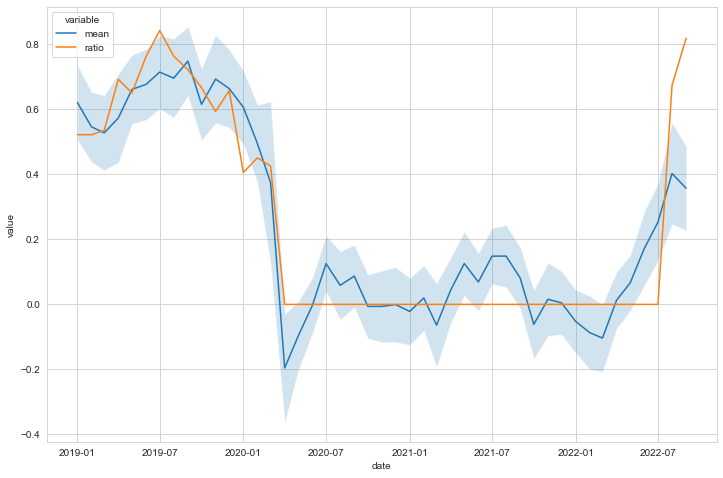

In [27]:
ratio_pred = res.get_prediction().summary_frame()
ratio_stats = pd.concat([temp, ratio_pred], axis=1)

ratio_viz_df = ratio_stats[["mean", "ratio", "date"]].melt(id_vars="date")

fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=ratio_viz_df, x="date", y="value", hue="variable")
ax.fill_between(data=ratio_stats, x="date", y1="mean_ci_lower",
                y2="mean_ci_upper", alpha=0.2)
plt.show()